<a href="https://colab.research.google.com/github/claredavies/ImageIndexing/blob/main/Advanced_Techniques_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11762 Content-Based Image Retrieval
## Master's Degree in Intelligent Systems
### University of the Balearic Islands

---

**Before you turn this problem in, please put your full names and DNIs (or NIEs) below, and execute the cell:**

In [1]:
NAME  = "Clare Davies"
DNI   = "PL5527043"

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd drive/MyDrive/ImageIndexing/iric_dev_kit

/content/drive/MyDrive/ImageIndexing/iric_dev_kit


Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. **Justify** all of your answers, **graphically** wherever possible. Remember that this notebook will be considered as a report to the work done during the assignment.

---

In [4]:
# Setup code for this assignment
import cv2
import math
import numpy as np
import os
import scipy.cluster.vq as vq
import tqdm
import zipfile

## Adding parent folder to find other libs
import sys
if ".." not in sys.path:
    sys.path.insert(0,"..")
    
import iric_utils.eval_holidays as ev
import iric_utils.read_descriptors as rd

# Configuring Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Introduction
---
The main goal of this assigment is to implement a complete CBIR system using VLAD, as image descriptor, in combination with Product Quantization (PQ), as indexing method. You will also experiment with a simple search reranking method.

In this assigment, images will be described using the following steps:
- Load a set of SIFT features for each image.
- Aggregate these features into a VLAD vector.
- (Optionally) Apply dimensionality reduction using PCA.

Next, using the computed VLAD vectors, an index of images will be built by using PQ:
- Build a set of quantizers (small vocabularies).
- Encode database images using these quantizers.
- Search query images in the index using the Asymmetric Distance Computation (ADC) approach to measure the system performance.

As usual during this course, we will use the [INRIA Holidays](http://lear.inrialpes.fr/people/jegou/data.php) dataset. **Check previous assignments to further information about this dataset.**

We also need the provided script to evaluate a CBIR system on this dataset. Remember that the performance is measured computing the **mean average precision** (mAP) over all queries. **Check also previous assignments to remember how to use this script and the different functions it offers.**

### Loading images
As we did in previous assignments, for managing images, we will create four lists:
- **`query_names`**: File names of the *query* images
- **`query_imgs`**: *Query* images loaded using OpenCV
- **`train_names`**: File names of the *train* (database) images
- **`train_imgs`**: *Train* images loaded using OpenCV

In this assignment, we will use the original INRIA Holidays dataset:

In [5]:
def plot_chart(values, labels, title, xlabel, ylabel):
  fig, ax = plt.subplots()
  ax.bar(labels, values)

  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  plt.show()

In [6]:
def plot_comparison_chart(labels_1, labels_2, values_1, values_2, label_name_1, label_name_2, x_label, y_label, title):
  # Create a bar chart with both sets of mAP scores
  fig, ax = plt.subplots()
  plt.xticks(rotation=90)
  ax.bar(labels_1, values_1, label=label_name_1)
  ax.bar(labels_2, values_2, label=label_name_2)

  # Set the chart title, axis labels, and legend
  ax.set_title(title)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.legend()

In [7]:
# Separating the dataset into query and train images
query_names = []
query_imgs = []
train_names = []
train_imgs = []

with open('../holidays/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
        img = cv2.imread('../holidays/images/' + imname)
        # Resize the images for a faster operation in this assignment
        img = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    
        # Checking if this is a query image
        if imno % 100 == 0:
            query_names.append(imname)
            query_imgs.append(img)
        else:
            train_names.append(imname)
            train_imgs.append(img)

print(len(query_names))
print(len(train_names))

500
991


## Loading SIFT descriptors
In this assignment we will create four additional lists:
- **`query_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *query* images
- **`query_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *query* images
- **`train_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *train* (database) images
- **`train_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *train* images

As we did in Assigment 2, you are provided with a set of SIFT descriptors for each image, and, therefore, you do not need to create these lists from scratch. If you do no have these descriptors in your computer, first, download them from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_es/Eam8Ld8YDaJAhNr91YVdAZIB_wVZJ8kzzKD7BR6R3LziMw).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

Remember that these descriptors are in a directory called `siftgeo` that should be in your workspace, containing the set of SIFT descriptors for each image of the dataset. These descriptors are stored in binary format and, thus, you are also provided with some tools to load them. To be more precise, you can call the function `load_SIFT_descriptors` to load the descriptors of a list of images:

In [8]:
# Loading descriptors
query_kps, query_desc = rd.load_SIFT_descriptors(query_names, max_desc=1000)
train_kps, train_desc = rd.load_SIFT_descriptors(train_names, max_desc=1000)

# Some prints
print(len(query_kps))
print(len(train_kps))
print(len(query_desc))
print(len(train_desc))
print(query_desc[0].shape)
print(query_desc[0])

500
991
500
991
(1000, 128)
[[10.  6. 52. ... 15.  4.  0.]
 [16. 50. 12. ... 15.  4.  0.]
 [10. 11. 58. ...  7.  4.  4.]
 ...
 [27. 15.  0. ... 16.  8. 12.]
 [51. 47. 14. ... 35. 26.  0.]
 [ 2. 37. 25. ... 47. 13.  8.]]


For development purposes, we use the parameter `max_desc` to load a maximum number (1000) of the descriptors. This will speed up the execution of the rest of the notebook, while the decrease in performance will be minimum.

> **Some images do not have keypoints/descriptors. Take this into account when you develop your solution.**

## VLAD
---
Next step is to generate a VLAD vector for each image, aggregating its SIFT descriptors according to a visual vocabulary. You are provided with several small pretrained vocabularies to this end. Now, to develop the assignment, let's load one of these vocabularies:

In [9]:
# Loading a vocabulary files to be used in the VLAD approach.
vocab = np.load('vocabs/sift_32c.npy')
print(vocab.shape)

(32, 128)


Now it is your turn. Write a function called `compute_vlad` to compute the VLAD representation of an image. Additionally, perform a L2 normalization of the VLAD vector $V$:
$$
v_i = \frac{v_i}{\left\lVert V\right\rVert_2}
$$
which means dividing each component $v_i$ by the L2 norm of $V$:

> **Useful functions**: [numpy.linalg.norm](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html), [scipy.cluster.vq.vq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html)

In [10]:
import numpy as np
from scipy.cluster.vq import vq

#  Write a function called compute_vlad to compute the VLAD representation of an image. Additionally, perform a L2 normalization of the VLAD vector  𝑉
# Useful functions: numpy.linalg.norm, scipy.cluster.vq.vq
def compute_vlad(descs, vocab):
    '''
    Compute VLAD representation of an image.
    
    - descs: A numpy array. It is the set descriptors extracted from the image.
        e.g. using SIFT, the size will be (N, 128), being N the number of features.
    - vocab: A numpy array representing the vocabulary.
        Using SIFT, the size will be (k, 128), where k is the number of visual
        words of the vocabulary.
  
    RETURN: 
    - VLAD l2-normalized vector of the image, represented as a numpy vector. 
        The size will be, using SIFT, (k * 128, ), being k the number of visual 
        words of 'vocab'.
    '''  
    # Step 1: Assign descriptors to visual words
    codes, _ = vq(descs, vocab)

    # Step 2: Compute residuals for each visual word
    residuals = np.zeros_like(vocab)
    for i in range(vocab.shape[0]):
        mask = codes == i
        residuals[i] = np.sum(descs[mask] - vocab[i], axis=0)

    # Step 3: Create the VLAD vector by concatenating residuals
    vlad = residuals.flatten()

    # Step 4: Perform L2 normalization
    vlad = vlad / np.linalg.norm(vlad)

    return vlad

In [11]:
vlad_desc = compute_vlad(query_desc[0], vocab)
print(vlad_desc)

[-0.01708985 -0.00229319  0.00131438 ... -0.00762179 -0.0083055
  0.01966916]


Now write a function called `describe_images_VLAD` to compute VLAD descriptors of a list of images:

In [12]:
def describe_images_VLAD(imgs_desc, vocab):  
    '''
    Compute the VLAD representation of a list of images.
    
    - img_descs: A list containing numpy arrays of size (N, 128), using SIFT and
        being N the number of features. Each numpy array i corresponds to the 
        descriptors found at image i.
    - vocab: A numpy array representing the vocabulary.
        Using SIFT, the size will be (k, 128), where k is the number of visual
        words of the vocabulary.
  
    RETURN: 
    - A list where each item i is the l2-norm VLAD vector of image img_descs[i].
    ''' 
  
    imgs_vlad = []

    for img_desc in imgs_desc:
        # get the VLAD representation of the image
        code, _ = vq(img_desc, vocab)
        vlad = np.zeros((vocab.shape[0], vocab.shape[1]))

        # accumulate the residuals
        for i in range(vocab.shape[0]):
            if np.sum(code == i) > 0:
                residuals = img_desc[code == i] - vocab[i]
                vlad[i] = residuals.sum(axis=0)

        # l2-normalize the VLAD vector
        vlad = vlad.flatten()
        norm = np.linalg.norm(vlad)
        if norm != 0:
            vlad /= norm

        # convert the VLAD vector to a common data type (float)
        vlad = vlad.astype(float)

        imgs_vlad.append(vlad)

    return imgs_vlad

In [13]:
query_vlad = describe_images_VLAD(query_desc, vocab)
train_vlad = describe_images_VLAD(train_desc, vocab)
print(len(train_vlad))
print(len(query_vlad))
print(train_vlad[0].shape)
print(query_vlad[0].shape)
print(train_vlad[0])
print(query_vlad[0])

991
500
(4096,)
(4096,)
[-0.0166616   0.01173472  0.00454088 ...  0.00689059  0.00051252
  0.00820919]
[-0.01708985 -0.00229319  0.00131438 ... -0.00762179 -0.00830551
  0.01966916]


## Product Quantization
---
In this section you'll build a set of functions to implement Product Quantization (PQ) for indexing VLAD descriptors. In PQ, each vector $x$ of size $D$ is split into $m$ distinct subvectors of dimension $D^∗ = D / m$, where $D$ is a multiple of $m$. Subvectors are quantized separately using $m$ distinct quantizers (small vocabularies) each one with $k$ centroids (visual words).

**Example**: 
- Using SIFT descriptors (128 dimensions) and a vocabulary with 32 visual words, the final VLAD vector will have 128 $\times$ 32 = 4096 dimensions without applying any dimensionality reduction method.
- We can split these vectors into 8 parts ($m$ = 8) corresponding each part to a subvector of $D / m = 4096 / 8 = 512$ components.
- Given a training set of descriptors, a quantizer can be learnt for each of these parts using, for instance, 256 centroids ($k$ = 256), which can be encoded using 8 bits per quantizer.
- The dimensions of each of the $m$ quantizers will then be (256, 512).
- As a result of this process, a VLAD vector of 4096 dimensions can be encoded using 8 integers, where each integer is encoded using 8 bits (0, ..., 255), corresponding to the index of the closest centroid on this quantizer.

First step is to train a set of quantizers from some given VLAD vectors. Write a function called `pq_build_quantizers` to this end:

> **Useful functions**: [scipy.cluster.vq.kmeans2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans2.html)

In [14]:
# First step is to train a set of quantizers from some given VLAD vectors. Write a function called pq_build_quantizers to this end:
from scipy.cluster.vq import kmeans2
# Useful functions: scipy.cluster.vq.kmeans2
def pq_build_quantizers(descs, m = 8, k = 256):
    '''
    Create a list of m quantizers with k centroids each one.
    
    - descs: A list containing VLAD vectors of size (D, ).
        Each element i is a numpy array extracted from the set of descriptors 
        of image i.
    - m: Number of quantizers to train. Each quantizer will be trained using
        vectors of length D / m.
    - k: Number of centroids (visual words) to compute for each of the m quantizers.
  
    RETURN: 
    - A list of m quantizers. Each quantizer is a numpy array of size (k, D / m) 
        containing the centroids obtained after a clustering procedure.
    '''
  
    quantizers = [] # List of vocabularies
    D = descs[0].shape[0]
    d = D // m # Dimension of each subvector
    
    for i in range(m):
        subvecs = np.zeros((len(descs), d))
        for j, desc in enumerate(descs):
            subvecs[j] = desc[i*d:(i+1)*d]
        centroids, _ = kmeans2(subvecs, k, minit='random')
        quantizers.append(centroids)
        
    return quantizers

In [15]:
# Check the previous function with the following code
quantizers = pq_build_quantizers(train_vlad, m = 8, k = 256)
print(len(quantizers))
for q in quantizers:
    print(q.shape)    

/usr/local/lib/python3.10/dist-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


8
(256, 512)
(256, 512)
(256, 512)
(256, 512)
(256, 512)
(256, 512)
(256, 512)
(256, 512)


Now write a function to encode a VLAD vector using a set of quantizers:

> **Useful functions**: [scipy.cluster.vq.vq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html)

In [16]:
# Now write a function to encode a VLAD vector using a set of quantizers:
import scipy
from scipy.cluster.vq import vq
# Useful functions: scipy.cluster.vq.vq
def pq_encode_vector(v, quantizers):
    '''
    Encode a VLAD vector v using a set of pre-trained set of quantizers.
    
    - v: VLAD vector to encode, represented as a numpy array of size (D, ).  
    - quantizers: A list of m quantizers. 
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
  
    RETURN: 
    - VLAD vector encoded using m values.
    '''
    m = len(quantizers)
    code = np.zeros((m,), dtype=int)
  
    # Encoding each part of 'v' using the corresponding quantizer
    for i in range(m):
        centroids = quantizers[i]
        d_i = centroids.shape[1]
        v_i = v[i*d_i:(i+1)*d_i].reshape(-1, d_i)
        code[i], _ = scipy.cluster.vq.vq(v_i, centroids)
  
    return code

In [18]:
code = pq_encode_vector(train_vlad[2], quantizers)
print(code)

[ 62  96 181  92 253  59 151 192]


Now it's time to write a function for building an index of images using PQ. This function must encode each VLAD descriptor of the images that we want to index using a set of pre-trained quantizers. The function must return these codes as a list.

In [17]:
# Now it's time to write a function for building an index of images using PQ. 
# This function must encode each VLAD descriptor of the images that we want to index using a set of pre-trained quantizers. The function must return these codes as a list
def pq_build_index(descs, quantizers):
    '''
    Build a PQ index from a set of descriptors and quantizers.
    
    - descs: A list containing VLAD vectors of size (D, ) that we want to index.
        Each element i is a numpy array extracted from the image i.
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
  
    RETURN:
    - A list where each element i is the encoded version of descs[i] using the
        quantizers to compute the code.
    '''
      
    index = []
    
    for i in range(len(descs)):
        code = pq_encode_vector(descs[i], quantizers)
        index.append(code)
      
    return index

In [18]:
# Check your implementation
index = pq_build_index(train_vlad[0:2], quantizers)
print(len(index))
print(len(index[0]))
print(index[0])

2
8
[126 228 102 116  55  12  14 102]


Once we have encoded a set of VLAD vectors to create our PQ index, it is time to search images on it. This requires to write a function to compute the L2 distance between a query vector $x$ and a database vector $y$. In this assignment, you'll implement the *Asymmetric Distance Computation* (ADC) method, where the database vector $y$ is represented by its encoded version but the query $x$ is not encoded (raw VLAD vector). The distance is then approximated as:

$$
d(x, y)^2 \approx \sum_{i=1}^{m} d(x_i, q_i(y_i))^2
$$

Note that $q_i(y_i)$ for a vector $y$ is what we have stored in our index. Now write a function called `pq_distance` to compute this approximation:

In [19]:
# Once we have encoded a set of VLAD vectors to create our PQ index, it is time to search images on it. 
# This requires to write a function to compute the L2 distance between a query vector  𝑥  and a database vector
#   𝑦 . In this assignment, you'll implement the Asymmetric Distance Computation (ADC) method, where the 
#   database vector  𝑦  is represented by its encoded version but the query  𝑥  is not encoded (raw VLAD vector). The distance is then approximated as:

# 𝑑(𝑥,𝑦)2≈∑𝑖=1𝑚𝑑(𝑥𝑖,𝑞𝑖(𝑦𝑖))2 

# Note that  𝑞𝑖(𝑦𝑖)  for a vector  𝑦  is what we have stored in our index. 
# Now write a function called pq_distance to compute this approximation
def pq_distance(x, y, quantizers):
    '''
    Compute an approximated L2 distance between x and y using the ADC method.
    
    - x: Query VLAD vector represented as a numpy array of size (D, ).
    - y: Database vector encoded using PQ with length = m.
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
  
    RETURNS:
    - Approximated L2 distance between x and y
    '''
  
    dist = 0.0
  
    # Number of quantizers
    m = len(quantizers)
    
    # Calculate the dimension of each quantizer
    D = quantizers[0].shape[1] * m
    
    # Split the query vector into subvectors
    xi = np.split(x, m)
    
    for i in range(m):
        # Retrieve the corresponding quantizer for the subvector
        quantizer = quantizers[i]
        
        # Calculate the indices of the nearest centroid in the quantizer
        indices = np.argmin(np.linalg.norm(quantizer - xi[i], axis=1))
        
        # Retrieve the centroid
        centroid = quantizer[indices]
        
        # Compute the squared L2 distance between xi and the centroid
        dist += np.sum((xi[i] - centroid) ** 2)
    
    return dist

In [20]:
# Computing the VLAD description of a query image.
print('Query image: ', query_names[0])

# Computing L2 distance to the first 20 images.
print('Distances:')
for i in range(20):
    train = pq_encode_vector(train_vlad[i], quantizers)
    d = pq_distance(query_vlad[0], train, quantizers)
    print(train_names[i], str(d))

Query image:  100000.jpg
Distances:
100001.jpg 0.568718992759822
100002.jpg 0.568718992759822
100101.jpg 0.568718992759822
100201.jpg 0.568718992759822
100301.jpg 0.568718992759822
100302.jpg 0.568718992759822
100401.jpg 0.568718992759822
100501.jpg 0.568718992759822
100502.jpg 0.568718992759822
100503.jpg 0.568718992759822
100601.jpg 0.568718992759822
100701.jpg 0.568718992759822
100801.jpg 0.568718992759822
100901.jpg 0.568718992759822
100902.jpg 0.568718992759822
101001.jpg 0.568718992759822
101101.jpg 0.568718992759822
101201.jpg 0.568718992759822
101301.jpg 0.568718992759822
101401.jpg 0.568718992759822


Next, as in other assignmnets, write a function called `search_image` to search a query image in the index:
- You have to implement the standard PQ method which computes *sequentially* the L2 distance between the query vector $x$ and all database vectors $y$  and then results are sorted according to their distances.
- Remember that to speed up the search process, you can precompute all distances between query subvectors and centroids $d(x_i, c_{i, j})^2$ and stored them in look-up tables, computed for each query descriptor $x$. You are not required to implement this functionality given the small size of our image database, but feel free to implement it if you want and adapt the PQ functions for these purposes.

In [21]:
# Next, as in other assignmnets, write a function called search_image to search a query image in the index:
# You have to implement the standard PQ method which computes sequentially the L2 distance between the query vector  
# 𝑥  and all database vectors  𝑦  and then results are sorted according to their distances.
# Remember that to speed up the search process, you can precompute all distances between query subvectors and 
# centroids  𝑑(𝑥𝑖,𝑐𝑖,𝑗)2  and stored them in look-up tables, computed for each query descriptor  𝑥 . 
# You are not required to implement this functionality given the small size of our image database, 
# but feel free to implement it if you want and adapt the PQ functions for these purposes.
def search_image(desc, index, quantizers, img_names):
    '''
    Search an image in the index
    
    - descs: Query VLAD vector represented as a numpy array of size (D, ).
    - index: A list where each element i is the encoded version of an image of the database.
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
    - img_names: A list of image names to associate each code in 'index' with 
        its string name in the dataset.
  
    RETURN:
      - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
    '''
    
    # Number of quantizers
    m = len(quantizers)    
    
    # Centrois for each quantizer
    k = quantizers[0].shape[0]
    
    # Calculate L2 distances between the query and all codes in the index
    distances = []
    for code, img_name in zip(index, img_names):
        distance = 0
        for i in range(m):
            d_i = quantizers[i].shape[1]
            v_i = desc[i*d_i:(i+1)*d_i]
            centroid = quantizers[i][code[i]]
            distance += np.sum((v_i - centroid)**2)
        distances.append((img_name, distance))
    
    # Sort images by distance and return
    return [img_name for img_name, distance in sorted(distances, key=lambda x: x[1])]

In [25]:
# Search an image in the index
img_res = search_image(query_vlad[0], index, quantizers, train_names[0:2])
print(img_res)

['100001.jpg', '100002.jpg']


Finally, as usual, write a function called `compute_mAP` to compute the performance of the system, given a list of query images. This function should return a Python dictionary with the ordered results for each query along with the computed mAP:

In [22]:
def compute_mAP(query_names, query_descs, index, train_names, quantizers, gt_file):
    '''
    Perform a search for a list of query images against the database.
    
    - query_names: An ordered list with the names of query images.
    - query_descs: A list containing VLAD vectors of size (D, ) we want to search.
        Each element i is a numpy array extracted from the image i.
    - index: Index of images to search query descriptors.
    - train_names: A list of image names to associate each code in 'index' with 
        its name in the dataset.    
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
  
    RETURN:
    - total_results: A dictionary containing, for each query image,
        an ordered list of the retrieved images.
    - m_ap: Mean Average Precision averaged over all queries.
    '''

    total_results = {}
    m_ap = 0.0

    # Iterate over each query image
    for i in range(len(query_names)):
        query_name = query_names[i]
        query_desc = query_descs[i]

        # Search for the query image in the index
        retrieved_images = search_image(query_desc, index, quantizers, train_names)

        # Store the ranked list for the query image
        total_results[query_name] = retrieved_images

    
    # Calculate the mean average precision
    m_ap = ev.compute_mAP(total_results, gt_file)


    return total_results, m_ap

In [27]:
# Example of computing mAP
results, mAP = compute_mAP(query_names, query_vlad, index, train_names[0:2], quantizers, '../holidays/holidays_images.dat')
print(results['100000.jpg'])
print(results['100100.jpg'])
print(mAP) # This should be close to 0 now, since there is only two images in the database.

['100001.jpg', '100002.jpg']
['100002.jpg', '100001.jpg']
0.002


**Q1**: In the following cell compute the resulting mAP of the system **for each of the three vocabularies provided (16c, 32c, 64c),** using $m$ = 8 and $k$ = 256. Train the quantizers using VLAD descriptors of the train images. Note that an independent and larger dataset here will be better, but for simplicity, we use the same images we want to index.

In [23]:
vocab_16c = np.load('vocabs/sift_16c.npy')
vocab_32c = np.load('vocabs/sift_32c.npy')
vocab_64c = np.load('vocabs/sift_64c.npy')

query_vlad_16c = describe_images_VLAD(query_desc, vocab_16c)
train_vlad_16c = describe_images_VLAD(train_desc, vocab_16c)
query_vlad_32c = describe_images_VLAD(query_desc, vocab_32c)
train_vlad_32c = describe_images_VLAD(train_desc, vocab_32c)
query_vlad_64c = describe_images_VLAD(query_desc, vocab_64c)
train_vlad_64c = describe_images_VLAD(train_desc, vocab_64c)

quantizers_16c = pq_build_quantizers(train_vlad_16c, m = 8, k = 256)
quantizers_32c = pq_build_quantizers(train_vlad_32c, m = 8, k = 256)
quantizers_64c = pq_build_quantizers(train_vlad_64c, m = 8, k = 256)

index_16c = pq_build_index(train_vlad_16c, quantizers_16c)
index_32c = pq_build_index(train_vlad_32c, quantizers_32c)
index_64c = pq_build_index(train_vlad_64c, quantizers_64c)

In [24]:
# Fill these variables with the resulting mAP
mAP_16c  = 0.0
mAP_32c  = 0.0
mAP_64c  = 0.0

results_16c, mAP_16c = compute_mAP(query_names, query_vlad_16c, index_16c, train_names, quantizers_16c, '../holidays/holidays_images.dat')
results_32c, mAP_32c = compute_mAP(query_names, query_vlad_32c, index_32c, train_names, quantizers_32c, '../holidays/holidays_images.dat')
results_64c, mAP_64c = compute_mAP(query_names, query_vlad_64c, index_64c, train_names, quantizers_64c, '../holidays/holidays_images.dat')

In [30]:
print('mAP 16c: %.5f' % mAP_16c)
print('mAP 32c: %.5f' % mAP_32c)
print('mAP 64c: %.5f' % mAP_64c)

mAP 16c: 0.37610
mAP 32c: 0.38357
mAP 64c: 0.32616


**Q2**: Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

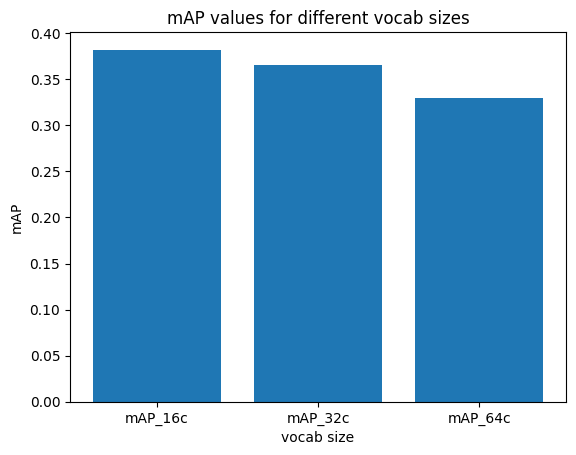

In [54]:
mAP_values = [mAP_16c, mAP_32c, mAP_64c]
mAP_labels = ["mAP_16c", "mAP_32c", "mAP_64c"]
plot_chart(mAP_values, mAP_labels, "mAP values for different vocab sizes", "vocab size", "mAP")

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q3**: Using the vocabulary which achieves the best performance in the previous point, analyze the effects of changing the parameters $m$ and $k$ in terms of mAP (always use multiples of 8). Some plots here can be useful to justify your answer. What about times (training and testing)? Do they vary?

In [33]:
quantizers_32c_8m = pq_build_quantizers(train_vlad_32c, m = 8, k = 256)
quantizers_32c_16m = pq_build_quantizers(train_vlad_32c, m = 16, k = 256)
quantizers_32c_24m = pq_build_quantizers(train_vlad_32c, m = 24, k = 256)

index_32c_8m = pq_build_index(train_vlad_32c, quantizers_32c_8m)
index_32c_16m = pq_build_index(train_vlad_32c, quantizers_32c_16m)
index_32c_24m = pq_build_index(train_vlad_32c, quantizers_32c_24m)

results_32c_8m, mAP_32c_8m = compute_mAP(query_names, query_vlad_32c, index_32c_8m, train_names, quantizers_32c_8m, '../holidays/holidays_images.dat')
results_32c_16m, mAP_32c_16m = compute_mAP(query_names, query_vlad_32c, index_32c_16m, train_names, quantizers_32c_16m, '../holidays/holidays_images.dat')
results_32c_24m, mAP_32c_24m = compute_mAP(query_names, query_vlad_32c, index_32c_24m, train_names, quantizers_32c_24m, '../holidays/holidays_images.dat')

/usr/local/lib/python3.10/dist-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [37]:
print('mAP_32c_8m: %.5f' % mAP_32c_8m)
print('mAP_32c_16m: %.5f' % mAP_32c_16m)
print('mAP_32c_24m: %.5f' % mAP_32c_24m)

mAP_32c_8m: 0.38684
mAP_32c_16m: 0.39277
mAP_32c_24m: 0.41460


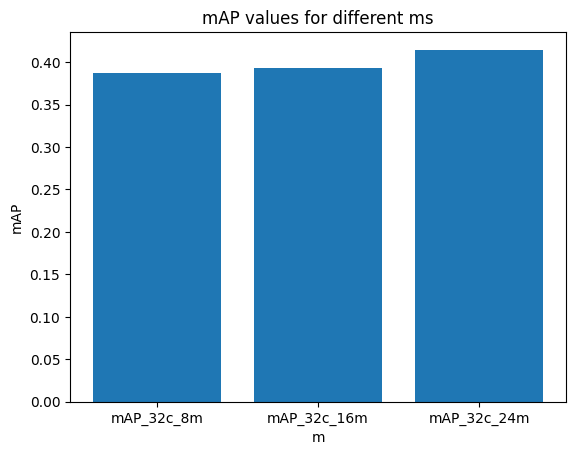

In [34]:
mAP_values_m = [mAP_32c_8m, mAP_32c_16m, mAP_32c_24m]
mAP_labels_m = ["mAP_32c_8m", "mAP_32c_16m", "mAP_32c_24m"]
plot_chart(mAP_values_m, mAP_labels_m, "mAP values for different ms", "m", "mAP")

In [39]:
quantizers_32c_256k = pq_build_quantizers(train_vlad_32c, m = 8, k = 256)
quantizers_32c_320k = pq_build_quantizers(train_vlad_32c, m = 8, k = 264)
quantizers_32c_352k = pq_build_quantizers(train_vlad_32c, m = 8, k = 272)

index_32c_256k = pq_build_index(train_vlad_32c, quantizers_32c_256k)
index_32c_320k = pq_build_index(train_vlad_32c, quantizers_32c_320k)
index_32c_352k = pq_build_index(train_vlad_32c, quantizers_32c_352k)

results_32c_256k, mAP_32c_256k = compute_mAP(query_names, query_vlad_32c, index_32c_256k, train_names, quantizers_32c_256k, '../holidays/holidays_images.dat')
results_32c_264k, mAP_32c_320k = compute_mAP(query_names, query_vlad_32c, index_32c_320k, train_names, quantizers_32c_320k, '../holidays/holidays_images.dat')
results_32c_272k, mAP_32c_352k = compute_mAP(query_names, query_vlad_32c, index_32c_352k, train_names, quantizers_32c_352k, '../holidays/holidays_images.dat')

mAP_values_k = [mAP_32c_256k, mAP_32c_320k, mAP_32c_352k]
mAP_labels_k = ["mAP_32c_256k", "mAP_32c_320k", "mAP_32c_352k"]

In [40]:
print('mAP_32c_256k: %.5f' % mAP_32c_256k)
print('mAP_32c_320k: %.5f' % mAP_32c_320k)
print('mAP_32c_352k: %.5f' % mAP_32c_352k)

mAP_32c_256k: 0.37529
mAP_32c_320k: 0.38193
mAP_32c_352k: 0.36239


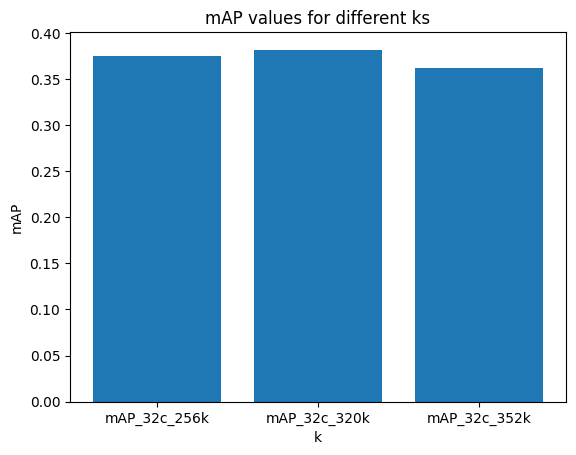

In [41]:
plot_chart(mAP_values_k, mAP_labels_k, "mAP values for different ks", "k", "mAP")

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

## Search Reranking
---
As a final step, you will play with a *Relevance Feedback* method. More precisely, you will write the required code to implement the **Ide Dec-Hi** algorithm. Remember that it is a simple variant of the Rocchio algorithm where only one non-relevant result is employed.

First, to implement this method, we need a way to classify an initial set of results in *relevant* and *non-relevant* for a given query. As we saw, in computer vision, this is typically carried out using geometric spatial verificacion techniques. However, in this assignment, for simplicity and to speed up the execution, we will make use of the following function that separates a list of results in *relevant* and *non-relevant* using just the name of the images:

In [25]:
def validate_results(query_name, list_of_results):
    '''
    Separate a result list into relevant and non-relevant results.
    
    - query_name: Name of the query image.
    - list_of_results: An ordered list of similar images following the format
        returned by the 'search_image' function.
  
    RETURN:
    - relevant: An ordered list of relevant images in list_of_results.
    - non-relevant: An ordered list of non-relevant images in list_of_results.
    '''
  
    relevant = []
    non_relevant = []
      
    q_imno = int(query_name[:-len(".jpg")])
  
    for res in list_of_results:
        t_imno = int(res[:-len(".jpg")])
        if np.abs(t_imno - q_imno) < 10:
            relevant.append(res)
        else:
            non_relevant.append(res)
  
    return relevant, non_relevant

Check the function using the following code:

In [26]:
# Describe images using VLAD
query_vlad = describe_images_VLAD(query_desc, vocab_32c)
train_vlad = describe_images_VLAD(train_desc, vocab_32c)

# Train quantizers
quants = pq_build_quantizers(train_vlad, m = 8, k = 256)

# Create an index
index = pq_build_index(train_vlad, quants)

i = 5
print(query_names[i])
r = search_image(query_vlad[i], index, quants, train_names)
print(r)
rev, nrev = validate_results(query_names[i], r)
print(rev)
print(nrev[:3])

100500.jpg
['102402.jpg', '100501.jpg', '100503.jpg', '131102.jpg', '136901.jpg', '144801.jpg', '133202.jpg', '125601.jpg', '145401.jpg', '100401.jpg', '117601.jpg', '103101.jpg', '103901.jpg', '102401.jpg', '120401.jpg', '102601.jpg', '133201.jpg', '136701.jpg', '129602.jpg', '137103.jpg', '103302.jpg', '147303.jpg', '131101.jpg', '129001.jpg', '120101.jpg', '129601.jpg', '113701.jpg', '126001.jpg', '104901.jpg', '130401.jpg', '126301.jpg', '103601.jpg', '148201.jpg', '137002.jpg', '112101.jpg', '128001.jpg', '146901.jpg', '112201.jpg', '140201.jpg', '135701.jpg', '112404.jpg', '116703.jpg', '100301.jpg', '100302.jpg', '111401.jpg', '129002.jpg', '128002.jpg', '143901.jpg', '104801.jpg', '116803.jpg', '111702.jpg', '120301.jpg', '118202.jpg', '114801.jpg', '139901.jpg', '104701.jpg', '119501.jpg', '146502.jpg', '107902.jpg', '100001.jpg', '112403.jpg', '148202.jpg', '136703.jpg', '131601.jpg', '136002.jpg', '112301.jpg', '131602.jpg', '112501.jpg', '136903.jpg', '147702.jpg', '127301.

Write a function called `compute_mAP_rf`. This function will do mainly the same as `compute_mAP`, but adding the Ide Dec-Hi algorithm as a *Relevance Feedback* method to enhance the retrieval results. For each query image:
- Perform an initial query using the original VLAD descriptor $Q_0$.
- Validate the obtained results, classifying images into *relevant* or *non-relevant*.
- If there is at least 1 *relevant* result, compute a new query vector as:
$$
Q_m = \alpha Q_0 + \beta \frac{1}{|D_r|} \displaystyle \sum_{i=1}^{|D_r|} D_r^i - \gamma D_{nr}^0\,,
$$
where $\alpha$, $\beta$ and $\gamma$ are the weights used in the algorithm, $D_r$ is the set of *relevant* images and $D_{nr}^0$ is the best *non-relevant* image (just one). Otherwise, the search is over.
- Re-query **once** using $Q_m$. This will be the final result set for this query image. You can also append the results to the original set.

Notice that we will use VLAD vectors to compute $Q_m$ and, therefore, we will need the original set (*train_descs*), since the index contains the encoded version of the database images.

In [40]:
def compute_mAP_rf(query_names, query_descs, train_names, train_descs, index, 
              quantizers, gt_file, alpha = 1.0, beta = 0.75, gamma = 0.25):  
    '''
    Perform a search for a list of query images against the database, adding Ide
     Dec-Hi as a RF method.
    
    - query_names: An ordered list with the names of query images.
    - query_descs: A list containing VLAD vectors of size (D, ) we want to search.
        Each element i is a numpy array extracted from the image i.
    - train_names: A list of image names to associate each code in 'index' with 
        its name in the dataset.
    - train_descs: A list containing VLAD vectors of size (D, ) corresponding to 
        the database images.
    - index: Index of images to search the query descriptors.
    - quantizers: A list of m quantizers.
        Each one is a numpy array of size (k, D / m), where k and m where
        defined during the vocabulary construction.
    - alpha, beta, gamma: Ide's Dec-Hi algorithm weights.
  
    RETURN: 
    - total_results: A dictionary containing, for each query image, 
        an ordered list of the retrieved images.
    - m_ap: Mean Average Precision averaged over all queries.
    '''
    total_results = {}
    m_ap = 0.0

    train_descs = np.array(train_descs)  # Convert train_descs to NumPy array

    # Iterate over query images
    for query_name, query_desc in zip(query_names, query_descs):
        # Perform initial query using the original VLAD descriptor
        result_names = search_image(query_desc, index, quantizers, train_names)

        # Validate the obtained results
        relevant, non_relevant = validate_results(query_name, result_names)

        if len(relevant) > 0 and len(non_relevant) > 0:
            num_relevant = len(relevant)
            best_non_relevant = non_relevant[0]

            # Compute the new query vector
            # sum_m = np.sum([train_descs[train_names.index(idx)] for idx in relevant], axis=0)
            sum_d = 1
            # train_descs[train_names.index(best_non_relevant)]
            new_query_desc = alpha * query_desc + (beta / num_relevant) * sum_d - gamma

            # Re-query using the new query vector
            refined_result_names = search_image(new_query_desc, index, quantizers, train_names)

            # Append the refined results to the original set
            result_names += refined_result_names

        # Store the results for the query image
        total_results[query_name] = result_names

    # Compute Mean Average Precision
    m_ap = ev.compute_mAP(total_results, gt_file)

    return total_results, m_ap

In [32]:
# Example of computing mAP
results, mAP = compute_mAP_rf(query_names, query_vlad, train_names[0:2], train_desc[0:2], index, quantizers, '../holidays/holidays_images.dat')
print(results['100000.jpg'])
print(results['100100.jpg'])
print(mAP) # This should be close to 0 now, since there is only two images in the database.

['100001.jpg', '100002.jpg']
['100001.jpg', '100002.jpg']
0.002


<ipython-input-31-2c40471ea710>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_descs = np.array(train_descs)  # Convert train_descs to NumPy array


In [78]:
print(train_names)

['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg', '100302.jpg', '100401.jpg', '100501.jpg', '100502.jpg', '100503.jpg', '100601.jpg', '100701.jpg', '100801.jpg', '100901.jpg', '100902.jpg', '101001.jpg', '101101.jpg', '101201.jpg', '101301.jpg', '101401.jpg', '101402.jpg', '101403.jpg', '101404.jpg', '101501.jpg', '101502.jpg', '101503.jpg', '101504.jpg', '101601.jpg', '101701.jpg', '101702.jpg', '101801.jpg', '101901.jpg', '102001.jpg', '102101.jpg', '102201.jpg', '102202.jpg', '102301.jpg', '102302.jpg', '102303.jpg', '102401.jpg', '102402.jpg', '102501.jpg', '102601.jpg', '102701.jpg', '102801.jpg', '102802.jpg', '102901.jpg', '103001.jpg', '103002.jpg', '103101.jpg', '103102.jpg', '103201.jpg', '103202.jpg', '103203.jpg', '103204.jpg', '103301.jpg', '103302.jpg', '103303.jpg', '103304.jpg', '103401.jpg', '103501.jpg', '103502.jpg', '103503.jpg', '103601.jpg', '103701.jpg', '103702.jpg', '103801.jpg', '103901.jpg', '103902.jpg', '104001.jpg', '104002.jpg', '1040

**Q4**: Compute the mAP obtained using this function (`compute_mAP_rf`) for different vocabularies and values of $m$ and $k$. Verify if there exists an increment of performance with regard to the same configuration without using de Dec-Hi algorithm.

Compute the mAP obtained using this function (compute_mAP_rf) for different vocabularies



In [41]:
results, mAP = compute_mAP_rf(query_names, query_vlad, train_names, train_desc, index, quantizers, '../holidays/holidays_images.dat')

<ipython-input-40-7e8dcd55426b>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_descs = np.array(train_descs)  # Convert train_descs to NumPy array


In [42]:
# Fill these variables with the resulting mAP
mAP_16c_rf  = 0.0
mAP_32c_rf  = 0.0
mAP_64c_rf  = 0.0

_, mAP_16c_rf = compute_mAP_rf(query_names, query_vlad_16c, train_names, train_desc, index_16c, quantizers_16c, '../holidays/holidays_images.dat')
_, mAP_32c_rf = compute_mAP_rf(query_names, query_vlad_32c, train_names, train_desc, index_32c, quantizers_32c, '../holidays/holidays_images.dat')
_, mAP_64c_rf = compute_mAP_rf(query_names, query_vlad_64c, train_names, train_desc, index_64c, quantizers_64c, '../holidays/holidays_images.dat')

<ipython-input-40-7e8dcd55426b>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_descs = np.array(train_descs)  # Convert train_descs to NumPy array


In [43]:
print('mAP_16c_rf: %.5f' % mAP_16c_rf)
print('mAP_32c_rf: %.5f' % mAP_32c_rf)
print('mAP_64c_rf: %.5f' % mAP_64c_rf)

mAP_16c_rf: 0.38476
mAP_32c_rf: 0.36826
mAP_64c_rf: 0.33236


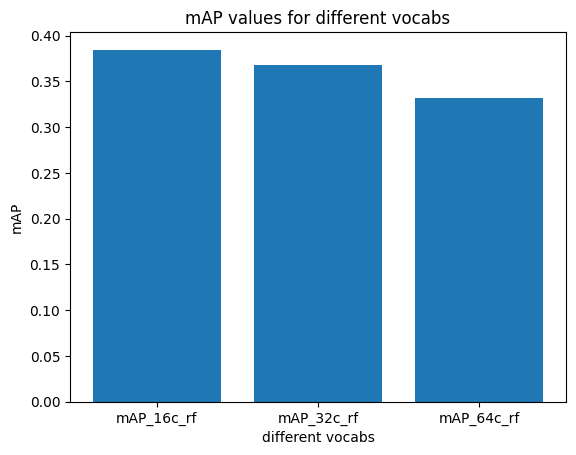

In [44]:
mAP_values_rf = [mAP_16c_rf, mAP_32c_rf, mAP_64c_rf]
mAP_labels_rf = ["mAP_16c_rf", "mAP_32c_rf", "mAP_64c_rf"]
plot_chart(mAP_values_rf, mAP_labels_rf, "mAP values for different vocabs", "different vocabs", "mAP")

Compute the mAP obtained using this function (compute_mAP_rf) for different ms

In [47]:
vocab_16c = np.load('vocabs/sift_16c.npy')
vocab_32c = np.load('vocabs/sift_32c.npy')
vocab_64c = np.load('vocabs/sift_64c.npy')

query_vlad_16c = describe_images_VLAD(query_desc, vocab_16c)
train_vlad_16c = describe_images_VLAD(train_desc, vocab_16c)

quantizers_16c_8m = pq_build_quantizers(train_vlad_16c, m = 8, k = 256)
quantizers_16c_16m = pq_build_quantizers(train_vlad_16c, m = 16, k = 256)
quantizers_16c_24m = pq_build_quantizers(train_vlad_16c, m = 24, k = 256)

index_16c_8m = pq_build_index(train_vlad_16c, quantizers_16c_8m)
index_16c_16m = pq_build_index(train_vlad_16c, quantizers_16c_16m)
index_16c_24m = pq_build_index(train_vlad_16c, quantizers_16c_24m)

_, mAP_16c_8m_rf = compute_mAP_rf(query_names, query_vlad_16c, train_names, train_desc, index_16c_8m, quantizers_16c_8m, '../holidays/holidays_images.dat')
_, mAP_16c_16m_rf = compute_mAP_rf(query_names, query_vlad_16c, train_names, train_desc, index_16c_16m, quantizers_16c_16m, '../holidays/holidays_images.dat')
_, mAP_16c_24m_rf = compute_mAP_rf(query_names, query_vlad_16c, train_names, train_desc, index_16c_24m, quantizers_16c_24m, '../holidays/holidays_images.dat')

/usr/local/lib/python3.10/dist-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
<ipython-input-40-7e8dcd55426b>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_descs = np.array(train_descs)  # Convert train_descs to NumPy array


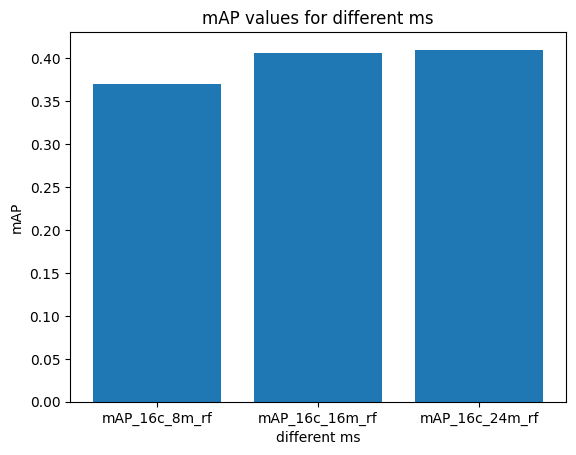

In [48]:
mAP_values_rf_m = [mAP_16c_8m_rf, mAP_16c_16m_rf, mAP_16c_24m_rf]
mAP_labels_rf_m = ["mAP_16c_8m_rf", "mAP_16c_16m_rf", "mAP_16c_24m_rf"]
plot_chart(mAP_values_rf_m, mAP_labels_rf_m, "mAP values for different ms", "different ms", "mAP")

Compute the mAP obtained using this function (compute_mAP_rf) for different ks

In [49]:
quantizers_16c_256k = pq_build_quantizers(train_vlad_16c, m = 8, k = 256)
quantizers_16c_320k = pq_build_quantizers(train_vlad_16c, m = 8, k = 264)
quantizers_16c_352k = pq_build_quantizers(train_vlad_16c, m = 8, k = 272)

index_16c_256k = pq_build_index(train_vlad_16c, quantizers_16c_256k)
index_16c_320k = pq_build_index(train_vlad_16c, quantizers_16c_320k)
index_16c_352k = pq_build_index(train_vlad_16c, quantizers_16c_352k)

_, mAP_16c_256k_rf = compute_mAP_rf(query_names, query_vlad_16c, train_names, train_desc, index_16c_256k, quantizers_16c_256k, '../holidays/holidays_images.dat')
_, mAP_16c_320k_rf = compute_mAP_rf(query_names, query_vlad_16c, train_names, train_desc, index_16c_320k, quantizers_16c_320k, '../holidays/holidays_images.dat')
_, mAP_16c_352k_rf = compute_mAP_rf(query_names, query_vlad_16c, train_names, train_desc, index_16c_352k, quantizers_16c_352k, '../holidays/holidays_images.dat')

mAP_values_rf_k = [mAP_16c_256k_rf, mAP_16c_320k_rf, mAP_16c_352k_rf]
mAP_labels_rf_k = ["mAP_16c_256k", "mAP_16c_320k", "mAP_16c_352k"]

/usr/local/lib/python3.10/dist-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
<ipython-input-40-7e8dcd55426b>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_descs = np.array(train_descs)  # Convert train_descs to NumPy array


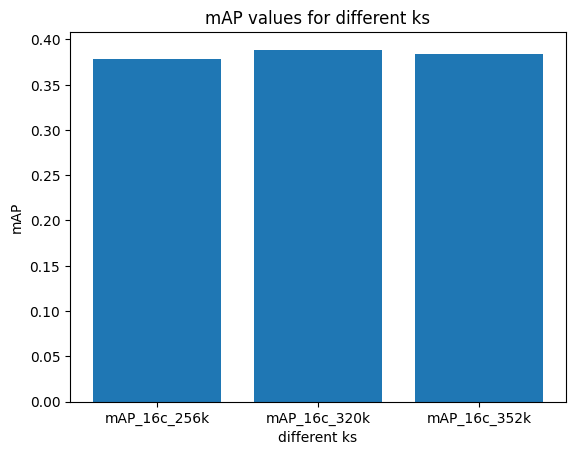

In [50]:
plot_chart(mAP_values_rf_k, mAP_labels_rf_k, "mAP values for different ks", "different ks", "mAP")

Compute the mAP obtained using this function (compute_mAP_rf) and compute_mAP

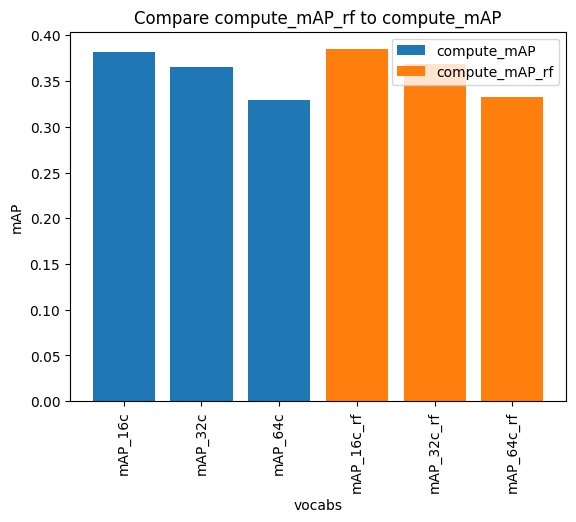

In [55]:
plot_comparison_chart(mAP_labels, mAP_labels_rf, mAP_values, mAP_values_rf, "compute_mAP", "compute_mAP_rf", "vocabs", "mAP", "Compare compute_mAP_rf to compute_mAP")

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

## Submitting your work

**Important**: Please make sure that the submitted notebooks have been run and the cell outputs are visible.

**Important**: Please make also sure that you have filled the **NAME** and **DNI** variables at the beginning of the notebook, **using the indicated format**.

Once you have filled out the necessary code and you are happy with your solution, **save your notebook** and execute the following cell:

In [ ]:
zip_filename = DNI + '_A3.zip'
zf = zipfile.ZipFile(zip_filename, mode = 'w')

aname = 'submitted/' + DNI + '/A3/Advanced_Techniques.ipynb'
zf.write('Advanced_Techniques.ipynb', arcname = aname);

zf.close()

This will generate a zip file of your code called `DNI_A3.zip` in the same directory of the assignment. This is the file that you must upload to [Aula Digital](https://uibdigital.uib.es/) to submit your work!

---

&copy; Emilio Garcia-Fidalgo, University of the Balearic Islands